# CSBDeep & Noise2Noise an Astrophotography Example
We use the [CSBDeep](http://csbdeep.bioimagecomputing.com/) training framework which was published with [CARE](https://www.nature.com/articles/s41592-018-0216-7). Furthermore we use the [Noise2Noise](https://arxiv.org/abs/1803.04189) training principle first described by Lehtinen _et al._

Noise2Noise states that multiple noisy observation are sufficient to train content aware image restoration networks. In other words, no ground truth data is required. This opens the door to many new applications where the acquisition of ground truth data is impossible or very time consuming. 

In this example we will train a content aware image restoration network with multiple subs from an astrophotography session.
The possibility of using this learning model for astrophotography is discussed by the authors in this video: https://www.youtube.com/watch?v=dcV0OfxjrPQ

The example here is based on learnings taken from examples in the CSBDeep repo `examples` and from the basic Noise2Noise example provided by Tim-Oliver Buchholz in the repo [
Noise2Noise-with-CSBDeep](https://github.com/juglab/Noise2Noise-with-CSBDeep). Additionally the CSBDeep team have provided an great video about their framework here: https://www.youtube.com/watch?v=ipp0mxfjhwY

Other contributions have been from learnings acquired from various astro forum posts on the topic of deep learning:

* https://www.cloudynights.com/topic/789780-deep-learning-denoising-for-astrophotography/
* https://www.cloudynights.com/topic/657928-deep-learning-for-random-noise-attenuation/

Enhancements have been provided by Maria Pavlou as code changes to the base CDBDeep repo.

In [1]:
# Allow reloading of CSBDeep modules following any code changes
%reload_ext autoreload
%autoreload 2

# A couple required imports
import numpy as np
import matplotlib.pyplot as plt
from tifffile import imread
from pathlib import Path

# Pre-processing Training Data and Save
We have a stack of sub frames in the `data/astro2/train` folder, acquired with the same optical train and equipment.
All images have been aligned and calibrated and saved in the tiff format.

The example data can be downloaded [here](https://1drv.ms/u/s!AvWEkn9Anb_Nq9Aw52Xs3LuYEcq_rg?e=EexXxL)

Place the train images in the `data/astro/train` folder.

In [2]:
# Setup Data Parameters:
# Root Data path
basepath=Path('data/astro')
# Train Data path/s
source_dirs=['train']
# Image file pattern. Note: only formats supported by imread currently
pattern='*.tiff'
# Image patch size
patchsize=64
# Training data output savefile path & name
training_data_name='TrainData_p64_nPERC'
training_data_filename=training_data_name + '.npz'
save_file=basepath/training_data_filename

In [3]:
# Make an estimate of the number of non-overlapping patches for the images we have, sampling from the first we find.
sampleimage = imread(list((basepath/source_dirs[0]).glob(pattern))[0])
n_patches_per_image=np.int(sampleimage.shape[0]/patchsize)*np.int(sampleimage.shape[1]/patchsize)

In [4]:

from csbdeep.data import RawData, create_patches, norm_percentiles, norm_reinhard

# Load image pairs for Noise2Noise processing, each image paired against every other at most once.
raw_data = RawData.from_folder_n2n(basepath, source_dirs=source_dirs, axes='YXC', pattern=pattern)

# Create patch data from image pairs with parameters,
# normalization set as norm_percentiles() by default, optionally set to None, norm_reinhard() or other custom
X, Y, XY_axes = create_patches(
    raw_data, 
    patch_size=(patchsize,patchsize,3),
    normalization=norm_percentiles(),
    n_patches_per_image=n_patches_per_image,
    save_file=save_file,
    patch_filter=None,
    overlap=False)

print('Source Data Shape =', X.shape)
print('Target Data Shape =', Y.shape)
print('Data Axes =', XY_axes)

  190 raw images x    1 transformations   =   190 images
  190 images     x  884 patches per image = 167960 patches in total
Input data:
data\astro:, sources='['train']', axes='YXC', pattern='*.tiff'
Transformations:
1 x Identity
Patch size:
64 x 64 x 3


d:\pydeep\CSBDeep\csbdeep\data\generate.py:330: RuntimeWarning: overflow encountered in long_scalars
  n_required_memory_bytes = 2 * n_patches*np.prod(patch_size) * 4
100%|██████████| 190/190 [02:46<00:00,  1.14it/s]


Saving data to data\astro\TrainData_p64_nPERC.npz.
Source Data Shape = (167960, 3, 64, 64)
Target Data Shape = (167960, 3, 64, 64)
Data Axes = SCYX


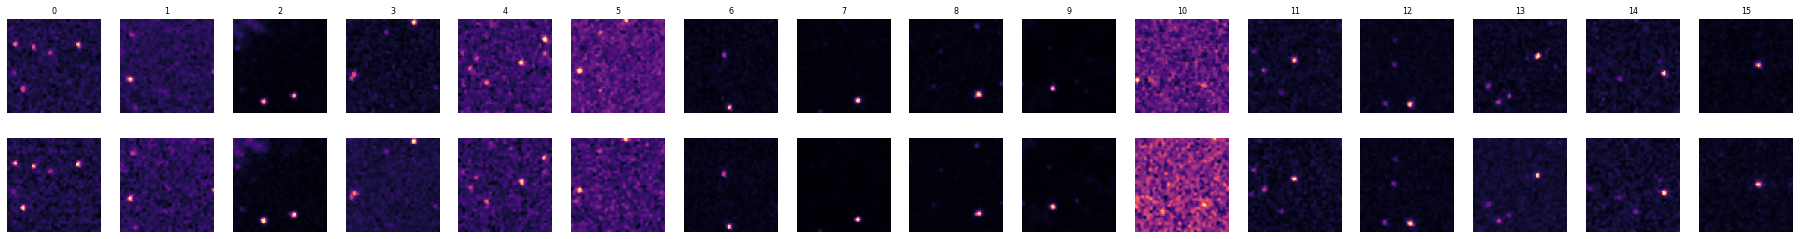

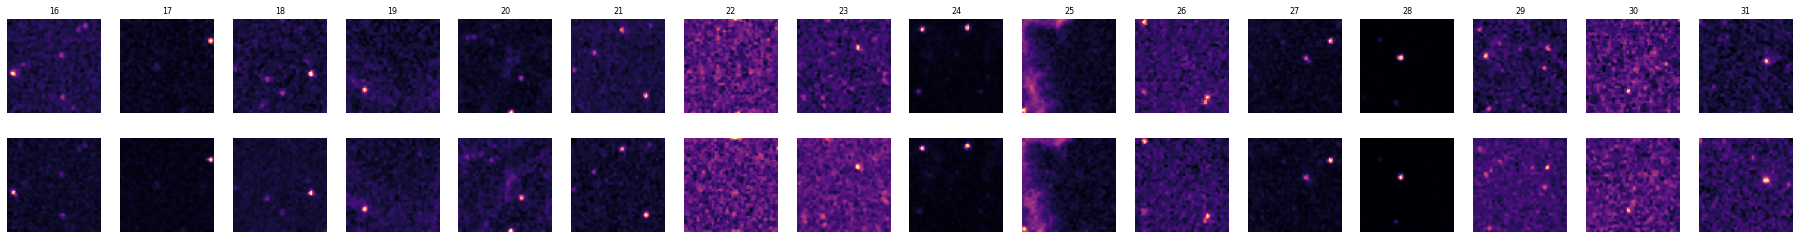

In [5]:
from csbdeep.utils import plot_some

# We can visualize the resulting patch input and target pairs.
for i in range(2):
    plt.figure(figsize=(32,4))
    sl = slice(16*i, 16*(i+1)), 0
    plot_some(X[sl],Y[sl],title_list=[np.arange(sl[0].start,sl[0].stop)])
    plt.show()

# Clear loaded data from memory, as an alternative axes order is required for subsequent steps.
del X,Y,XY_axes

# Load Training Data
Here we load the training data from a save file created in earlier steps.
As data is loaded we can also split the data into training `X,Y` and validation `X_val,Y_val` sets.

In [6]:
from csbdeep.io import load_training_data
# Train/Validation split %
validation_split=0.1
# Load saved training data to memory from save file
(X,Y), (X_val,Y_val), axes = load_training_data(save_file, validation_split=validation_split, verbose=True)

print('Source Train Data Shape =', X.shape)
print('Target Train Data Shape =', Y.shape)
print('Source Val Data Shape =', X_val.shape)
print('Target Val Data Shape =', Y_val.shape)

number of training images:	 151164
number of validation images:	 16796
image size (2D):		 (64, 64)
axes:				 SYXC
channels in / out:		 3 / 3
Source Train Data Shape = (151164, 64, 64, 3)
Target Train Data Shape = (151164, 64, 64, 3)
Source Val Data Shape = (16796, 64, 64, 3)
Target Val Data Shape = (16796, 64, 64, 3)


# Configure and Train the Learning Model

Here we configure the training model parameters. 
Training will be done for each color channel separately and saved with individual names based on:

* `training_data_name`
* `model_base_name`
* `channel_name[i]`

## Training debug tools

You can monitor the progress during training with [TensorBoard](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard) by starting it from the current working directory:

    $ tensorboard --logdir=.

Then connect to [http://localhost:6006/](http://localhost:6006/) with your browser.

In [8]:
# Importing the deep learning framework
from csbdeep.models import Config, CARE

# Since we are training each channel separately: n_channel_in, n_channel_out = 1, 1
# Probabilistic training will be used as this yields better results
# Reccomended that train_steps_per_epoch set at 200-400, and train_epochs at 100-200 for good results.
config = Config('SYXC', n_channel_in=1, n_channel_out=1, unet_kern_size=3, probabilistic=True, train_steps_per_epoch=100, train_epochs=50)

# Give a name for the model
model_base_name = '_ASTRO_01_01'

model_name = training_data_name + model_base_name
channel_names=['R', 'G', 'B']
for i in range(3):
    full_model_name = model_name + '_' + channel_names[i]
    
    # Create the Learning Model from the CARE framework with configuration
    model = CARE(config, name=full_model_name, basedir='models')
    
    # Train the model and capture history
    history = model.train(
        X[:,:,:,i,np.newaxis], 
        Y[:,:,:,i,np.newaxis], 
        (X_val[:,:,:,i,np.newaxis], Y_val[:,:,:,i,np.newaxis]))
    
    # Save the model
    model.export_TF()

Epoch 1/50
Cause: could not parse the source code of <function _mean_or_not.<locals>.<lambda> at 0x000001B10E22F3A0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names.
Match 0:
(lambda x: K.mean(x, axis=(- 1)))

Match 1:
(lambda x: x)

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function _mean_or_not.<locals>.<lambda> at 0x000001B10E22F3A0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names.
Match 0:
(lambda x: K.mean(x, axis=(- 1)))

Match 1:
(lambda x: x)

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function _mean_or_not.<locals>.<lambda> at 0x000001B10E22F550>: found 

d:\pydeep\CSBDeep\csbdeep\utils\tf.py:177: UserWarning: 
***IMPORTANT NOTE***

You are using 'tensorflow' 2.x, hence it is likely that the exported model *will not work*
in associated ImageJ/Fiji plugins (e.g. CSBDeep and StarDist).

If you indeed have problems loading the exported model in Fiji, the current workaround is
to load the trained model in a Python environment with installed 'tensorflow' 1.x and then
export it again. If you need help with this, please read:

https://gist.github.com/uschmidt83/4b747862fe307044c722d6d1009f6183

  warnings.warn(\



Model exported in TensorFlow's SavedModel format:
D:\pydeep\CSBDeep\models\TrainData_p64_nPERC_ASTRO_01_01_R\TF_SavedModel.zip
Epoch 1/50
Cause: could not parse the source code of <function _mean_or_not.<locals>.<lambda> at 0x000001B138AC6940>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names.
Match 0:
(lambda x: K.mean(x, axis=(- 1)))

Match 1:
(lambda x: x)

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function _mean_or_not.<locals>.<lambda> at 0x000001B138AC6940>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names.
Match 0:
(lambda x: K.mean(x, axis=(- 1)))

Match 1:
(lambda x: x)

To silence this warning, decorate the function with @tf.autograph.experimental.

# Load and De-noise an Image 

Here we load an example image to de-noise using the trained set of RGB models.

The image to be de-noised must be normalized in the same way as the training data.
Then for each channel the model is used to predict the de-noised output and these are then saved as a single RGB image.

The example test image used can be downloaded [here](https://1drv.ms/u/s!AvWEkn9Anb_Nq9Aw52Xs3LuYEcq_rg?e=EexXxL).

Place the test image in the `data/astro/test` folder.

In [9]:
# Specify the test file
test_file_name='CrescentNebula-NoSt-Deep.tiff'

testfilepath=basepath/'test'/test_file_name
x = imread(testfilepath)
testaxes = 'YX'

print('Test Image size =', x.shape)
print('Test Image axes =', testaxes)

Test Image size = (2771, 4048, 3)
Test Image axes = YX


In [10]:
from csbdeep.data import PercentileNormalizer, PadAndCropResizer, ReinhardNormalizer, NoNormalizer

channel_names=['R', 'G', 'B']

output_denoised = []
for i in range(x.shape[2]):
    full_model_name = model_name + '_' + channel_names[i]
    
    # Load the model for the specific channel
    print("Loading model:", full_model_name)
    model = CARE(config=None, name=full_model_name, basedir='models')

    # Predict/de-noise the image channel with the corresponding trained model
    # Default PercentileNormalizer is used to match the normalization used to train the model
    output_denoised.append(
        model.predict(x[:,:,i],testaxes, normalizer=PercentileNormalizer(), resizer=PadAndCropResizer())
    )

Loading model: TrainData_p64_nPERC_ASTRO_01_01_R
Loading network weights from 'weights_best.h5'.
Out of memory, retrying with n_tiles = (1, 2)
Out of memory, retrying with n_tiles = (2, 2)


100%|██████████| 4/4 [00:00<00:00,  8.40it/s]


Loading model: TrainData_p64_nPERC_ASTRO_01_01_G
Loading network weights from 'weights_best.h5'.
Out of memory, retrying with n_tiles = (1, 2)
Out of memory, retrying with n_tiles = (2, 2)


100%|██████████| 4/4 [00:00<00:00,  8.08it/s]


Loading model: TrainData_p64_nPERC_ASTRO_01_01_B
Loading network weights from 'weights_best.h5'.
Out of memory, retrying with n_tiles = (1, 2)
Out of memory, retrying with n_tiles = (2, 2)


100%|██████████| 4/4 [00:00<00:00,  8.71it/s]


In [11]:
# Load astropy library for saving the de-noised image in fits format
from astropy.io import fits

output_file_name = model_name + '_RGB_' + Path(test_file_name).stem + '.fits'
output_file_path = basepath/'test'/output_file_name
hdu = fits.PrimaryHDU(output_denoised)
hdul = fits.HDUList([hdu])
hdul.info()
hdul.writeto(output_file_path)
print("Output file saved:", output_file_path)

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   (4048, 2771, 3)   float32   
Output file saved: data\astro\test\TrainData_p64_nPERC_ASTRO_01_01_RGB_CrescentNebula-NoSt-Deep.fits
